In [62]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

Count matrices have been downloaded from [GSE158399](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158399)

### Importing data

In [2]:
#primary tumor
df_prim=pd.read_table('GSM4798908_B2019-1.expression_matrix.txt.gz')
df_prim.head()

ACCAACCATGGG  CGTTTCCTAGCT  GATCTTCCTGAT  TCCTATCCCTCG  \
NAXE                 0             2             1             5   
C1orf122             2             3             3             5   
COX4I1              13            12             8            10   
CAVIN1               1             6             1             1   
CCND1               82            38            46            29   

          CATAATATTGGC  AGTTGTTGATTC  TGGTCAACATGG  AAATATGGTCGC  \
NAXE                 5             1             3             1   
C1orf122             2             4             5             4   
COX4I1               8            13            15             7   
CAVIN1               0             1             0             0   
CCND1               37            13            51            39   

          AGATAATCACGG  GACATCTCGAAG  ...  TTTTCTTGCTTA  GCAGAATCATGA  \
NAXE                 9             1  ...             0             0   
C1orf122             7             4  ...             0             0   
COX4I1               7             8  ...             0             0   
CAVIN1               1             0  ...             0             0   
CCND1               38            64  ...             0             1   

          GCTCAGTACGAC  GTCATCCTCACC  TTCACGAGATCT  AGCATAGCCGCG  \
NAXE                 0             0             0             0   
C1orf122             0             1             0             0   
COX4I1               0             1             1             0   
CAVIN1               5             0             0             1   
CCND1                0             1             1             0   

          AGTTGTGGGAGG  ATTGAGAGCTGT  CGTTGAGACCAT  TCCAATGGATAT  
NAXE                 0             0             0             1  
C1orf122             0             0             0             0  
COX4I1               0             0             0             0  
CAVIN1               0             2             2             1  
CCND1                0             0             0             1  

[5 rows x 11467 columns]

In [3]:
#lymph node positive for metastatic cells
df_pos=pd.read_table('GSM4798909_B2019-2.expression_matrix.txt.gz')
df_pos.head()

GTGTCTATAAGA  GATATTCCCCCT  CTAGCTAGCCAT  CAGCGATACCTG  TTTTGGTCTATG  \
TMOD3              0             0             0             1             3   
SRFBP1             1             4             0             1             2   
PDIA3             59            42            37            24            35   
MRPS33             1             3             3             4             3   
YBX1               8             2             0             2             3   

        TGAGTTAGCGTA  GAGATAATTAGA  TCCAATTTTTGA  GGTTTTGCGCCG  GTTCCGACCATT  \
TMOD3              3             2             2             2             1   
SRFBP1             1             1             3             1             0   
PDIA3             44            59            44            36            23   
MRPS33             1             4             0             1             1   
YBX1               7             1             3             4             1   

        ...  GGCGTATCAACC  GGTCGAACGCGC  GGTTTTGCACCG  GTGTTCTGATAT  \
TMOD3   ...             0             0             0             0   
SRFBP1  ...             0             0             0             0   
PDIA3   ...             0             0             1             0   
MRPS33  ...             0             0             0             0   
YBX1    ...             0             0             0             0   

        TACTTTTTGGTG  TAGAATTACGCG  TCGTGGAATCAC  TGATCGCACGTA  TGTTTCTCTCAG  \
TMOD3              0             0             0             0             0   
SRFBP1             0             0             0             0             0   
PDIA3              2             0             0             0             0   
MRPS33             0             0             0             0             0   
YBX1               0             0             2             0             0   

        TTCCGGTTCAGT  
TMOD3              1  
SRFBP1             0  
PDIA3              0  
MRPS33             0  
YBX1               0  

[5 rows x 11356 columns]

In [4]:
df_pos=df_pos.T
df_prim=df_prim.T

Retain only genes that are in common between the two sets

In [7]:
genes=list(set(df_prim.columns)&set(df_pos.columns))

In [8]:
df_prim=df_prim[genes]
df_pos=df_pos[genes]

In [9]:
DF=pd.concat([df_pos,df_prim])

In [10]:
adata=ad.AnnData(DF)

In [13]:
lista=[]
for x in adata.obs.index:
    if x in df_prim.index:
        lista.append('PT')
    elif x in df_pos.index:
        lista.append('LP')

In [14]:
adata.obs['tissue']=lista

### Preprocessing 

In [15]:
adata.obs_names_make_unique() 
adata.var_names_make_unique() 

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [17]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [20]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [22]:
sc.pp.log1p(adata)

In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5)

In [24]:
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [27]:
sc.pp.scale(adata, max_value=10)

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

In [29]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

In [30]:
sc.tl.umap(adata)

In [31]:
sc.tl.leiden(adata)

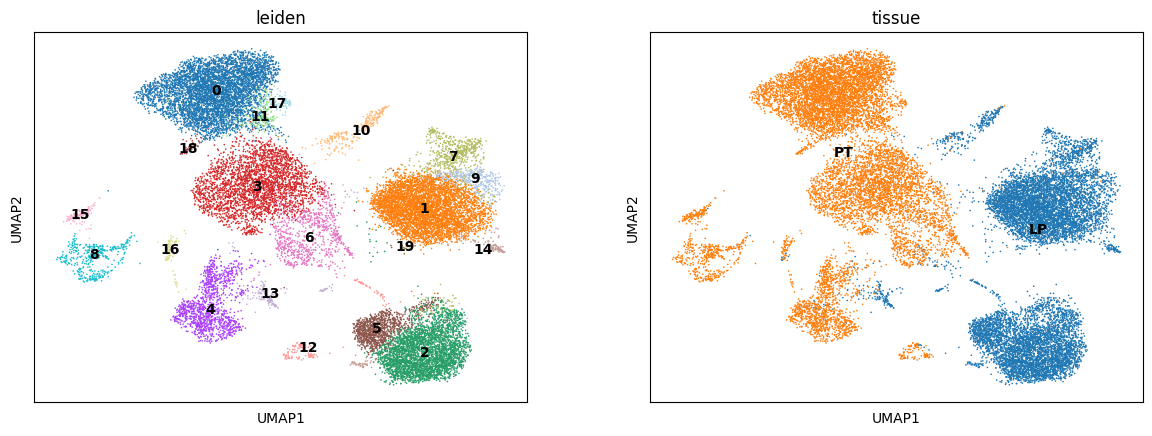

In [40]:
sc.pl.umap(adata,color=['leiden','tissue'],legend_loc='on data')

### Cell type labelling
We were able to assign cell identity, according to marker genes identified in [Xu et al.](https://academic.oup.com/hmg/article/30/5/370/6131713?login=true)

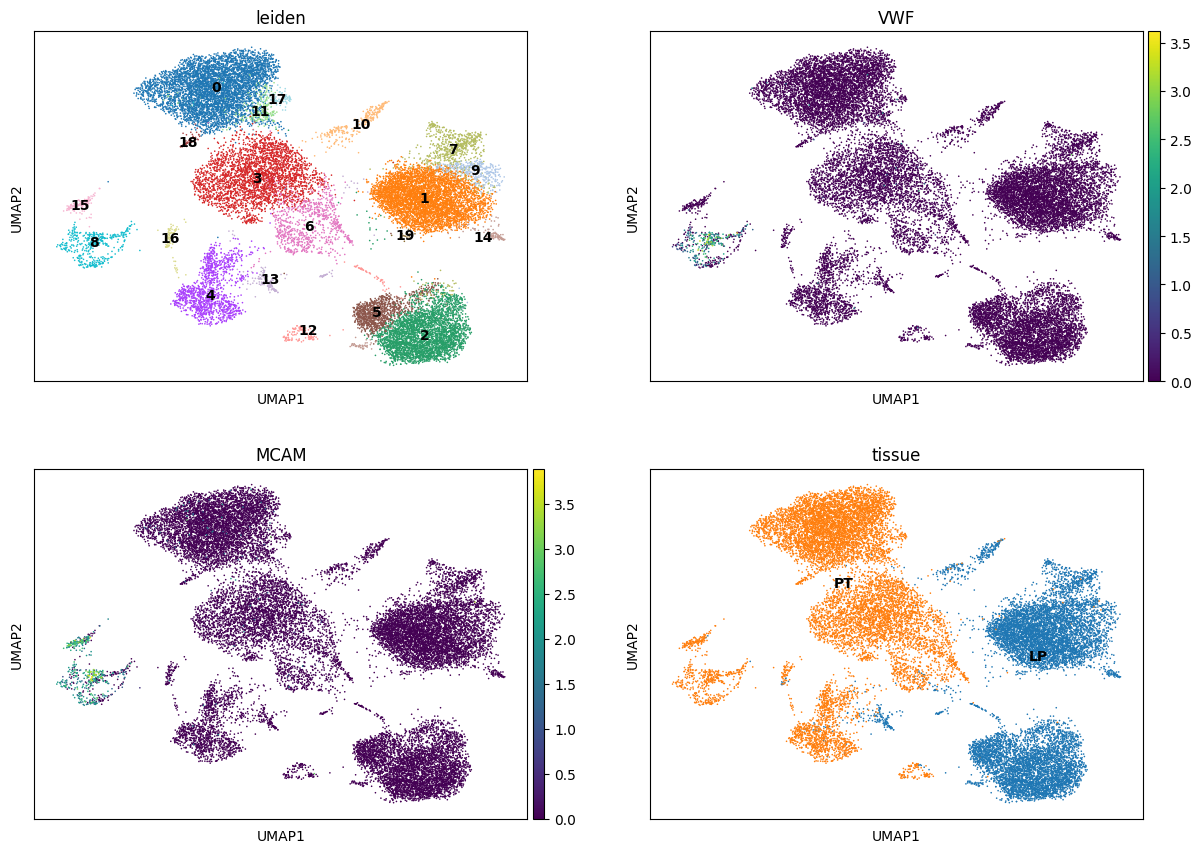

In [43]:
#endothelial
sc.pl.umap(adata,color=['leiden','VWF','MCAM','tissue'],legend_loc='on data',ncols=2)

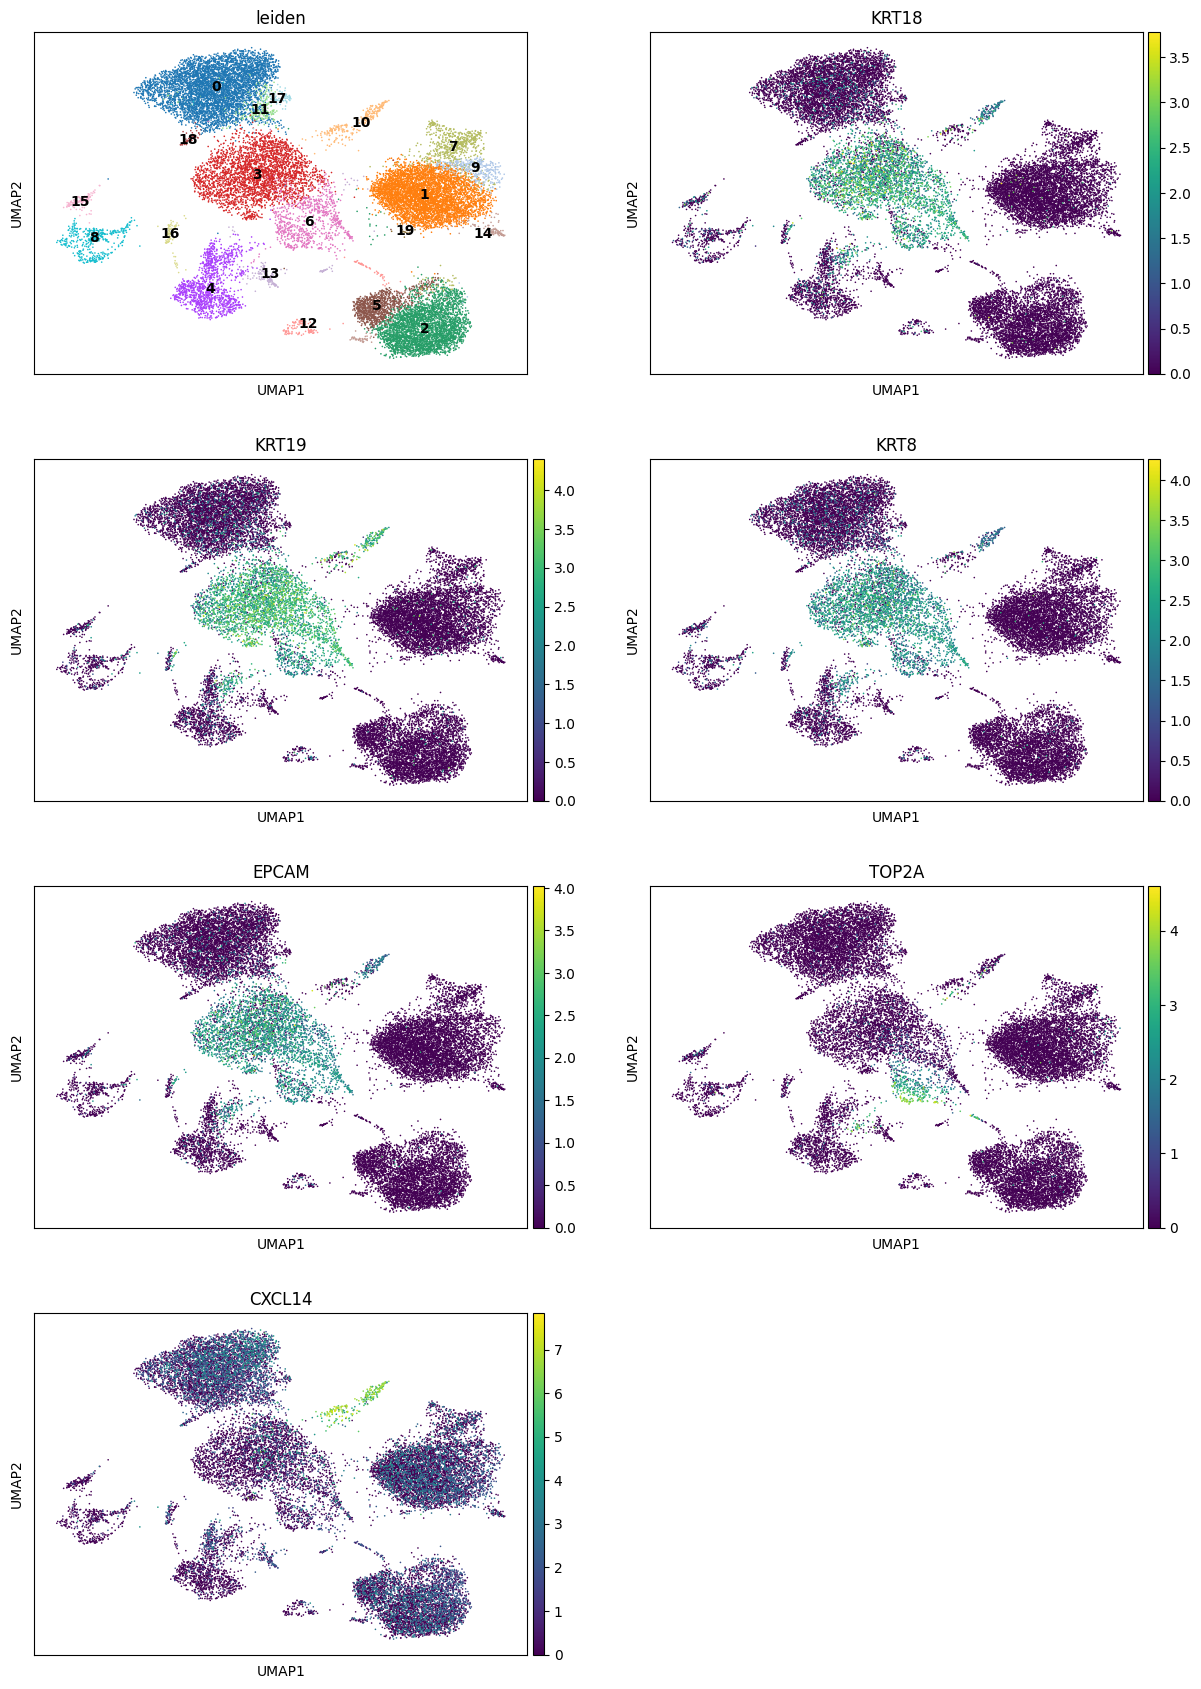

In [44]:
#cancer cells
sc.pl.umap(adata,color=['leiden','KRT18','KRT19','KRT8','EPCAM','TOP2A','CXCL14'],legend_loc='on data',ncols=2)

We performed this analysis for each marker available and we ended up with this cluster-cell_type assignment:

In [45]:
cell_label=[]
for i in adata.obs['leiden']:
    if i == str(10):
        cell_label.append('metastatic_cells')
    elif i == str(8):
        cell_label.append('endothelial')
    elif (i == str(0))|(i == str(18))|(i == str(11))|(i == str(17)):
        cell_label.append('myofibroblasts')
    elif i == str(8):
        cell_label.append('endothelial')
    elif i == str(3):
        cell_label.append('cancer_cells')
    elif i == str(6):
        cell_label.append('cancer_stem_cells')
    elif (i == str(9))|(i == str(1))|(i == str(14))|(i == str(19)):
        cell_label.append('naive_T')
    elif i == str(7):
        cell_label.append('CD8_effectors')
    elif i == str(12):
        cell_label.append('plasma_cells')
    elif i == str(4):
        cell_label.append('macrophages')
    elif i == str(13):
        cell_label.append('myeloid')
    elif i == str(15):
        cell_label.append('perycites')
    elif (i == str(5))|(i == str(2)):
        cell_label.append('B_cells')
    else:
        cell_label.append('unknown')

In [46]:
adata.obs['cell_type']=cell_label

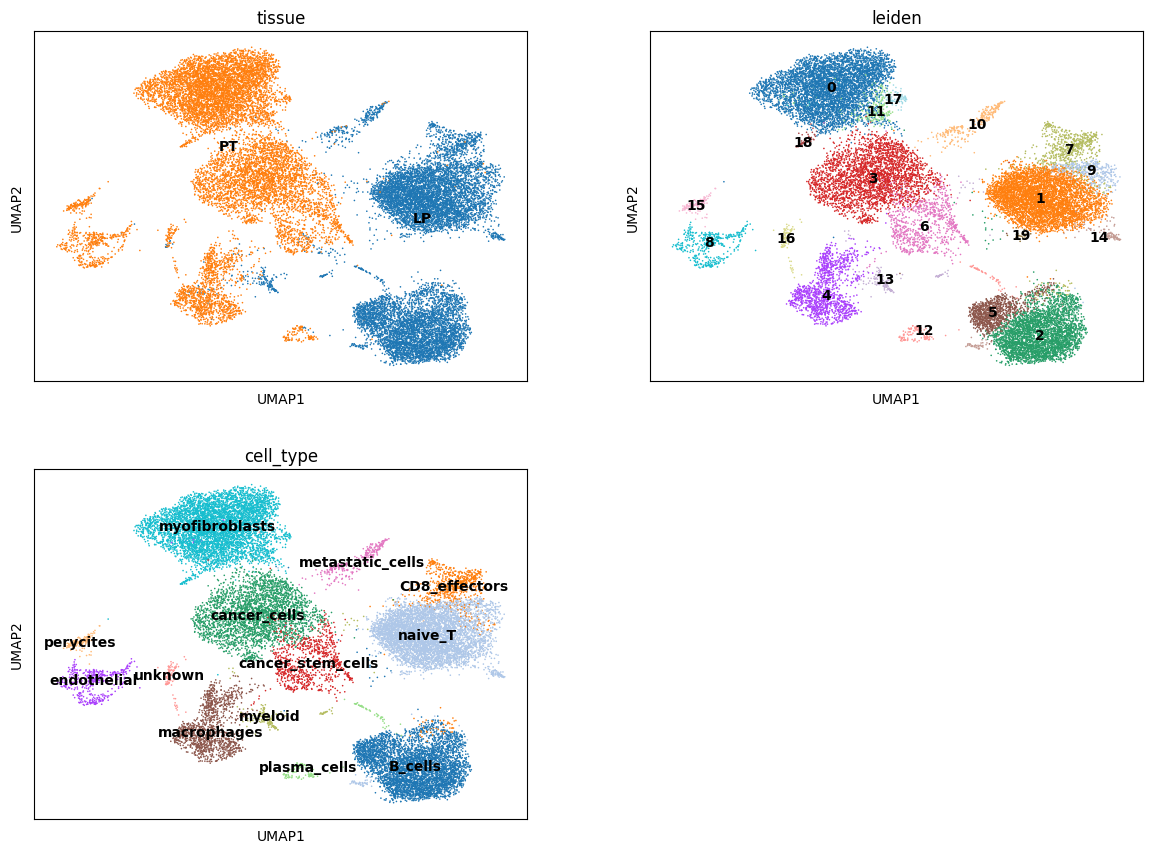

In [47]:
sc.pl.umap(adata, color=['tissue', 'leiden','cell_type'],legend_loc='on data',ncols=2)

### Gene signature enrichment
for each cell we computed the enrichment for three signatures:

    1. Memory signature
    2. Responsive signature
    3. Dormancy singature
    
Memory and Responsive signature are represented by the 150 most expressed genes after the second RA stimulus in nascent RNA seq experiment.

The enrichment score were computed as follows: for each cell the median expression value of genes of a specific signature was considered as the enrichment score

In [48]:
matrix=adata.X

In [49]:
mem_genes=pd.read_table('/home/morelli/Downloads/ranked_memory_FPKM.txt',header=None)
mem_genes=mem_genes[1].tolist()
res_genes=pd.read_table('/home/morelli/Downloads/ranked_responsive_FPKM.txt',header=None)
res_genes=res_genes[1].tolist()
res_genes=res_genes[:150]
mem_genes=mem_genes[:150]
dorm=pd.read_excel('/home/morelli/Scaricati/Dormancy signature.xlsx')
dorm_genes=[x.strip().upper() for x in dorm['Figure 2F - Dormancy genes'].tolist()]

In [55]:
matrix=adata.X
ids_mem=[]
for i in range(len(adata.var_names)):
    if adata.var_names[i] in mem_genes:
        ids_mem.append(i)
        
median_mem=[]
for c in range(matrix.shape[0]):
    med=[]
    for i in ids_mem:
        med.append(matrix[c,i])
    median_mem.append(np.median(med))
    
adata.obs['mem_sig']=median_mem

In [59]:
matrix=adata.X
ids_res=[]
for i in range(len(adata.var_names)):
    if adata.var_names[i] in res_genes:
        ids_res.append(i)
        
median_res=[]
for c in range(matrix.shape[0]):
    med=[]
    for i in ids_res:
        med.append(matrix[c,i])
    median_res.append(np.median(med))
    
adata.obs['res_sig']=median_res

In [60]:
matrix=adata.X
ids_dorm=[]
for i in range(len(adata.var_names)):
    if adata.var_names[i] in dorm_genes:
        ids_dorm.append(i)
        
median_dorm=[]
for c in range(matrix.shape[0]):
    med=[]
    for i in ids_dorm:
        med.append(matrix[c,i])
    median_dorm.append(np.median(med))
    
adata.obs['dorm_sig']=median_dorm

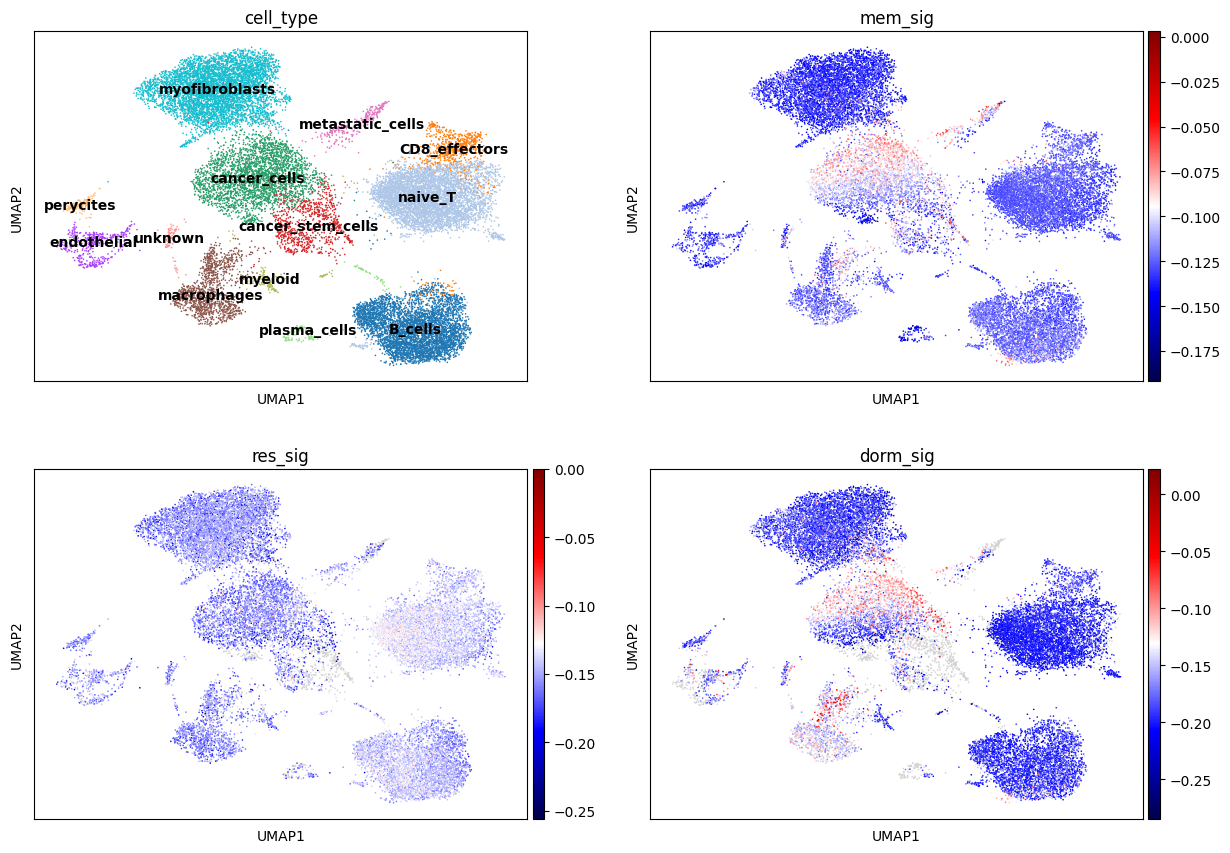

In [61]:
sc.pl.umap(adata,color=['cell_type','mem_sig','res_sig','dorm_sig'],ncols=2,legend_loc='on data',cmap='seismic')

### Memory - Dormancy correlation

In [63]:
ad=adata.obs.dropna(subset='dorm_sig')
ad=ad.dropna(subset='mem_sig')

In [64]:
scipy.stats.pearsonr(ad['dorm_sig'],ad['mem_sig'])

(0.6913012018441501, 0.0)

In [65]:
a, b = np.polyfit(ad['dorm_sig'],ad['mem_sig'], 1)

Text(0, 0.5, 'Memory Signature')

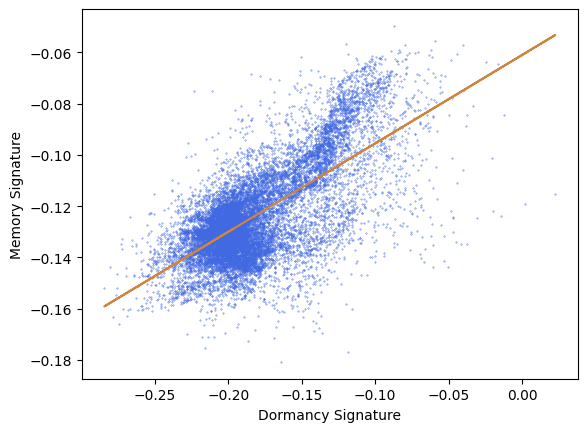

In [66]:
fig, ax = plt.subplots()
plt.scatter(ad['dorm_sig'],ad['mem_sig'],s=0.1,color='royalblue')
plt.plot(ad['dorm_sig'], a*ad['dorm_sig']+b,color='peru')  
plt.xlabel('Dormancy Signature')
plt.ylabel('Memory Signature')